<a href="https://colab.research.google.com/github/xhxuciedu/CS206/blob/master/l1_trend_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $\ell_1$ trend filtering

A derivative work by Judson Wilson, 5/28/2014.<br>
Adapted from the CVX example of the same name, by Kwangmoo Koh, 12/10/2007

Topic Reference:

* S.-J. Kim, K. Koh, S. Boyd, and D. Gorinevsky, ``l_1 Trend Filtering''<br>
http://stanford.edu/~boyd/papers/l1_trend_filter.html

## Introduction

The problem of estimating underlying trends in time series data arises in a variety of disciplines. The $\ell_1$ trend filtering method produces trend estimates $x$ that are piecewise linear from the time series $y$.

The $\ell_1$ trend estimation problem can be formulated as
    \begin{array}{ll}
    \mbox{minimize}   &  (1/2)||y-x||_2^2 + \lambda ||Dx||_1,
    \end{array}
with variable $x$ , and problem data $y$ and $\lambda$, with $\lambda >0$.
$D$ is the second difference matrix, with rows 
    $$\begin{bmatrix}0 & \cdots & 0 & -1 & 2 & -1 & 0 & \cdots & 0 \end{bmatrix}.$$
CVXPY is not optimized for the $\ell_1$ trend filtering problem.
For large problems, use l1_tf (http://www.stanford.edu/~boyd/l1_tf/).

## Formulate and solve problem

In [0]:
import numpy as np
import pandas as pd
import scipy as scipy
import scipy.sparse as sparse
import matplotlib.pyplot as plt

## load data

In [0]:
# download data
# imported the requests library 
import requests 
data_url = "https://drive.google.com/uc?export=download&id=1fAFU6DMI8Xt-nF0YcAq1XPc0Hs3p88Gf"
r = requests.get(data_url) # create HTTP response object 
  
# send a HTTP request to the server and save the HTTP response in a response object called r 
with open("snp500.csv",'wb') as f: 
    # Saving received content as a file 
    # write the contents of the response (r.content) 
    # to a new file in binary mode. 
    f.write(r.content) 

In [0]:
SPY = pd.read_csv('snp500.csv', header=None, names=['date','price'], parse_dates=['date'])

In [0]:
SPY = SPY.set_index('date')

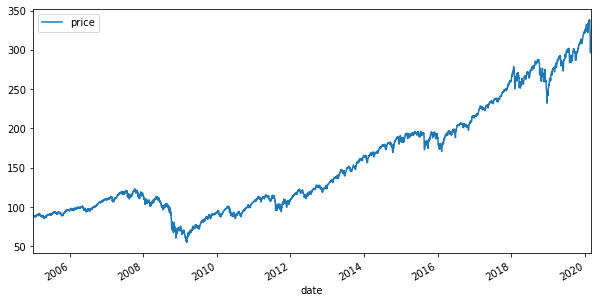

In [251]:
SPY.plot(figsize=(10,5))

In [0]:
data = SPY['price']['2017':]

In [0]:
# Load time series data: S&P 500 price log.
#y = np.loadtxt(open('data/snp500.txt', 'rb'), delimiter=",", skiprows=1)
y = data.values
n = y.size

# Form second difference matrix.
e = np.ones((1, n))
D = sparse.spdiags(np.vstack((e, -2*e, e)), range(3), n-2, n)

## Subgradient method

In [0]:
#x = np.random.randn(n)
x = y.copy()

In [0]:
def loss(x,y,D):
    return np.linalg.norm(x-y)**2/2 + vlambda*np.linalg.norm(D*x,1)

In [301]:
t = 1e-5 
vlambda = 50
for i in range(150000):
  dx = x-y + vlambda*D.T.dot(np.sign(D*x)) # gradient
  x -= t*dx
  
  if i%5000 == 0:
    print(i, loss(x,y,D))

0 88567.40325007781
5000 10655.0240892831
10000 7481.378089476337
15000 6236.862725473443
20000 5582.750204997933
25000 5189.592105581267
30000 4935.601876681686
35000 4772.233389599617
40000 4662.086197555547
45000 4569.437152427115
50000 4493.617870477365
55000 4428.643854218492
60000 4377.47940607224
65000 4331.219459094715
70000 4291.433326992523
75000 4261.480473414531
80000 4239.149490172328
85000 4217.946827949447
90000 4194.6632827449685
95000 4177.321985286158
100000 4166.77435931254
105000 4148.413926001487
110000 4135.673944234363
115000 4124.204653729808
120000 4117.692287667032
125000 4107.695725843364
130000 4100.922287149873
135000 4095.1800028666157
140000 4083.7922260006953
145000 4079.867632219013


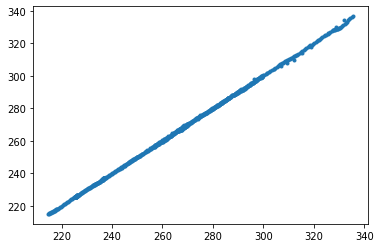

In [302]:
plt.plot(x2, x,   '.')

In [289]:
#x2 = x.value
loss(x2,y,D)

3981.0697153738906

##  Use cvxpy to solve the problem

In [0]:
import cvxpy as cp
import cvxopt as cvxopt

In [255]:
# Set regularization parameter.
vlambda = 50

# Solve l1 trend filtering problem.
x = cp.Variable(shape=n)
obj = cp.Minimize(0.5 * cp.sum_squares(y - x)
                  + vlambda * cp.norm(D*x, 1) )
prob = cp.Problem(obj)

# ECOS and SCS solvers fail to converge before
# the iteration limit. Use CVXOPT instead.
prob.solve(solver=cp.CVXOPT, verbose=True)
print('Solver status: {}'.format(prob.status))

# Check for error.
if prob.status != cp.OPTIMAL:
    raise Exception("Solver did not converge!")

print("optimal objective value: {}".format(obj.value))

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -1.0000e+00  2e+06  1e-01  4e-02  1e+00
 1:  2.2669e+02  2.4614e+02  2e+06  1e-01  4e-02  2e+01
 2: -1.4429e+02  3.9345e+00  2e+06  1e-01  4e-02  2e+02
 3: -6.8835e+01  7.0022e+01  1e+06  7e-02  2e-02  1e+02
 4:  4.1348e+02  5.7010e+02  1e+06  7e-02  2e-02  2e+02
 5: -1.2612e+02  1.1485e+02  6e+05  4e-02  1e-02  2e+02
 6:  7.6088e+01  2.5384e+02  4e+05  3e-02  7e-03  2e+02
 7:  9.3038e+02  1.1129e+03  4e+05  3e-02  7e-03  2e+02
 8:  8.0347e+02  8.9064e+02  2e+05  1e-02  3e-03  9e+01
 9:  1.8726e+03  1.9144e+03  7e+04  5e-03  1e-03  4e+01
10:  2.2036e+03  2.2272e+03  4e+04  3e-03  7e-04  2e+01
11:  2.7131e+03  2.7371e+03  4e+04  3e-03  7e-04  2e+01
12:  2.7184e+03  2.7314e+03  2e+04  1e-03  4e-04  1e+01
13:  3.3731e+03  3.3775e+03  7e+03  5e-04  1e-04  4e+00
14:  3.7551e+03  3.7564e+03  2e+03  1e-04  4e-05  1e+00
15:  3.8911e+03  3.8915e+03  8e+02  5e-05  1e-05  5e-01
16:  3.9436e+03  3.9439e+03  4e+02  3e-05  8e-06  

## Results plot

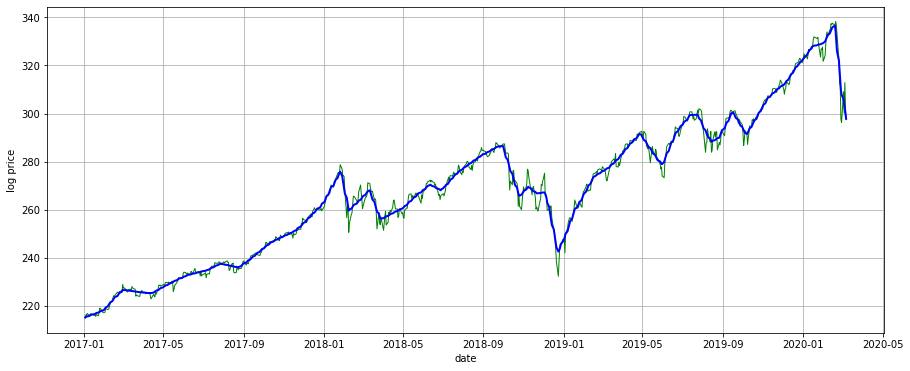

In [303]:
# Plot estimated trend with original signal.
fig,ax = plt.subplots(figsize=(15, 6))
ax.plot(data.index, y, 'g-', linewidth=1.0)
ax.plot(data.index, np.array(x), 'b-', linewidth=2.0)
ax.set_xlabel('date')
ax.set_ylabel('log price')
ax.grid()